# Using Gambit with OpenSpiel

This tutorial demonstrates the interoperability of the Gambit and OpenSpiel Python packages for game-theoretic analysis.

Where Gambit is used to compute exact equilibria for games, OpenSpiel provides a variety of iterative learning algorithms that can be used to approximate strategies. Another key distinction is that the PyGambit API allows the user a simple way to define custom games (see tutorials 1-3). This is also possible in OpenSpiel for normal form games, and you can load `.efg` files created from Gambit for extensive form, however some of the key functionality for iterated learning of strategies is only available for games from the built-in library (see the [OpenSpiel documentation](https://openspiel.readthedocs.io/en/latest/games.html)).

This tutorial demonstrates:

1. Loading examples of normal (strategic) form and extensive form games from the OpenSpiel library into Gambit
2. Training agents in OpenSpiel to play games and create strategies
3. Comparing the strategies of agents trained in OpenSpiel against equilibria strategies computed with Gambit

Note:
- The version of OpenSpiel used in this tutorial is `1.6.1`. If you are running this tutorial locally, this will be the version installed via the included `requirements.txt` file.
- You can find an introductory tutorial for the OpenSpiel API on colab [here](https://colab.research.google.com/github/deepmind/open_spiel/blob/master/open_spiel/colabs/OpenSpielTutorial.ipynb).

In [13]:
from io import StringIO
import numpy as np

from open_spiel.python import rl_environment
from open_spiel.python.algorithms import tabular_qlearner
from open_spiel.python.algorithms.gambit import export_gambit
from open_spiel.python.egt import dynamics
from open_spiel.python.egt.utils import game_payoffs_array

import pyspiel

import pygambit as gbt

## OpenSpiel game library

The [library of games](https://openspiel.readthedocs.io/en/latest/games.html) included in OpenSpiel is extensive. Many of these games will not be amenable to equilibrium computation with Gambit, due to their size. For the purposes of this tutorial, we'll pick two smaller games from the list below, one normal form and one extensive form:

In [14]:
print(pyspiel.registered_names())

['2048', 'add_noise', 'amazons', 'backgammon', 'bargaining', 'battleship', 'blackjack', 'blotto', 'breakthrough', 'bridge', 'bridge_uncontested_bidding', 'cached_tree', 'catch', 'checkers', 'chess', 'cliff_walking', 'clobber', 'coin_game', 'colored_trails', 'connect_four', 'coop_box_pushing', 'coop_to_1p', 'coordinated_mp', 'crazy_eights', 'cribbage', 'cursor_go', 'dark_chess', 'dark_hex', 'dark_hex_ir', 'deep_sea', 'dots_and_boxes', 'dou_dizhu', 'efg_game', 'einstein_wurfelt_nicht', 'euchre', 'first_sealed_auction', 'gin_rummy', 'go', 'goofspiel', 'hanabi', 'havannah', 'hearts', 'hex', 'hive', 'kriegspiel', 'kuhn_poker', 'laser_tag', 'leduc_poker', 'lewis_signaling', 'liars_dice', 'liars_dice_ir', 'lines_of_action', 'maedn', 'mancala', 'markov_soccer', 'matching_pennies_3p', 'matrix_bos', 'matrix_brps', 'matrix_cd', 'matrix_coordination', 'matrix_mp', 'matrix_pd', 'matrix_rps', 'matrix_rpsw', 'matrix_sh', 'matrix_shapleys_game', 'mfg_crowd_modelling', 'mfg_crowd_modelling_2d', 'mfg_dy

## Normal form games from the OpenSpiel library

Let's start with a simple normal form game of rock-paper-scissors, in which the payoffs can be represented by a 3x3 matrix.

Load matrix rock-paper-scissors from OpenSpiel:

In [117]:
ops_matrix_rps_game = pyspiel.load_game("matrix_rps")

In order to simulate a playthrough of the game, you can first initialise a game state:

In [130]:
state = ops_matrix_rps_game.new_initial_state()
state

Terminal? false
Row actions: Rock Paper Scissors 
Col actions: Rock Paper Scissors 
Utility matrix:
0,0 -1,1 1,-1 
1,-1 0,0 -1,1 
-1,1 1,-1 0,0 

The possible actions for both players are Rock, Paper and Scissors, but these must be accessed via integer indices:

In [132]:
print(state.legal_actions(0))
print(state.legal_actions(1))

[0, 1, 2]
[0, 1, 2]


Since Rock-paper-scissors is a 1-step simultaneous-move normal form game, we'll apply a list of player actions in one step to reach the terminal state.

Let's simulate player 1 playing Rock (0) and player 2 playing Paper (1):

In [133]:
state.apply_actions([0, 1])
state

Terminal? true
History: 0, 1
Returns: -1,1
Row actions: 
Col actions: 
Utility matrix:
0,0 -1,1 1,-1 
1,-1 0,0 -1,1 
-1,1 1,-1 0,0 

OpenSpiel can generate an NFG representation of the game loadable in Gambit:

In [18]:
nfg_matrix_rps_game = pyspiel.game_to_nfg_string(ops_matrix_rps_game)
nfg_matrix_rps_game

'NFG 1 R "OpenSpiel export of matrix_rps()"\n{ "Player 0" "Player 1" } { 3 3 }\n\n0 0\n1 -1\n-1 1\n-1 1\n0 0\n1 -1\n1 -1\n-1 1\n0 0\n'

Now let's load the NFG in Gambit (bear in mind that Gambit's `read_nfg` function expects a file like object).

In [35]:
gbt_matrix_rps_game = gbt.read_nfg(StringIO(nfg_matrix_rps_game))

gbt_matrix_rps_game.title = "Rock-Paper-Scissors"

for player in gbt_matrix_rps_game.players:
    player.strategies[0].label = "Rock"
    player.strategies[1].label = "Paper"
    player.strategies[2].label = "Scissors"

gbt_matrix_rps_game

,Rock,Paper,Scissors
Rock,"0,0","-1,1","1,-1"
Paper,"1,-1","0,0","-1,1"
Scissors,"-1,1","1,-1","0,0"


The equilibrium strategy for both players is to choose rock, paper, and scissors with equal probability:

In [20]:
gbt.nash.lcp_solve(gbt_matrix_rps_game).equilibria[0]

[[Rational(1, 3), Rational(1, 3), Rational(1, 3)], [Rational(1, 3), Rational(1, 3), Rational(1, 3)]]

We can use OpenSpiel's dynamics module to demonstrate evolutionary game theory dynamics, or "replicator dynamics", which models how strategy population frequencies change over time based on relative fitness/payoffs.

Let's start with an initial population that is not at equilibrium, but weighted quite heavily towards scissors with proportions: 20% Rock, 20% Paper, 60% Scissors:

In [228]:
matrix_rps_payoffs = game_payoffs_array(ops_matrix_rps_game)
dyn = dynamics.SinglePopulationDynamics(matrix_rps_payoffs, dynamics.replicator)
x = np.array([0.2, 0.2, 0.6])
dyn(x)

array([ 0.08, -0.08,  0.  ])

`dyn(x)` calculates the rate of change (derivative) for each strategy in the current population state and returns how fast each strategy's frequency is changing.

In replicator dynamics, strategies that perform better than average will increase in frequency, while strategies performing worse will decrease. Since Scissors beats Paper but loses to Rock, and this population has few Rock players, we'd expect:

- Scissors frequency might decrease (vulnerable to Rock)
- Rock frequency might increase (beats the abundant Scissors)
- Paper frequency might decrease (loses to abundant Scissors)

This is part of the evolutionary path toward the Nash equilibrium where all three strategies have equal frequency (1/3 each) in Rock-Paper-Scissors.

In [255]:
x = np.array([0.2, 0.2, 0.6])
alpha = 0.1
y = []
for i in range(100):
    x += alpha * dyn(x)
    y.append(x.copy())
print(x)

[0.10322948 0.46846987 0.42830065]


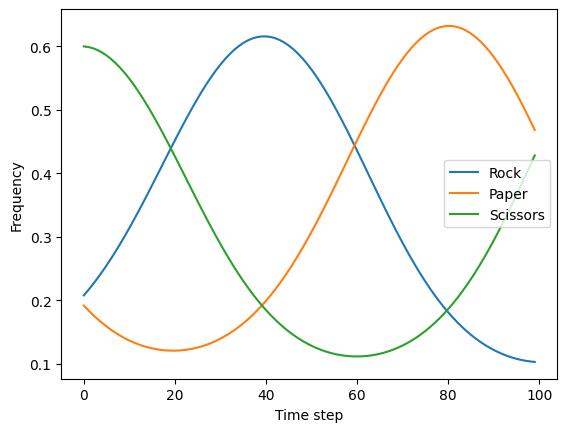

In [256]:
# Plot rock, paper and scissors frequencies over time
import matplotlib.pyplot as plt
y = np.array(y)
plt.plot(y[:, 0], label="Rock")
plt.plot(y[:, 1], label="Paper")
plt.plot(y[:, 2], label="Scissors")
plt.xlabel("Time step")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Normal form games created with Gambit

You can also set up a normal form game in Gambit and export it to OpenSpiel. Here we demonstrate this with the Prisoner's Dilemma game.

Note: in OpenSpiel version `1.6.1` there is a `pyspiel.load_nfg_game()` function, but it only seems to work for nfg's created by OpenSpiel, not games created by Gambit, where an error is thrown. Instead here we use Gambit to read the nfg file and convert it to NumPy arrays, which are then used to create a matrix game in OpenSpiel.

In [147]:
gbt_prisoners_dilemma_game = gbt.read_nfg("games/prisoners_dilemma.nfg")
gbt_prisoners_dilemma_game

,Cooperate,Defect
Cooperate,"-1,-1","-3,0"
Defect,"0,-3","-2,-2"


In [155]:
gbt.nash.lcp_solve(gbt_prisoners_dilemma_game).equilibria[0]

[[Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1)]]

In [152]:
p1_payoffs, p2_payoffs = gbt_prisoners_dilemma_game.to_arrays(dtype=float)
ops_prisoners_dilemma_game = pyspiel.create_matrix_game(
    gbt_prisoners_dilemma_game.title,
    "Classic Prisoner's Dilemma",  # description
    [strategy.label for strategy in gbt_prisoners_dilemma_game.players[0].strategies],
    [strategy.label for strategy in gbt_prisoners_dilemma_game.players[1].strategies],
    p1_payoffs,
    p2_payoffs
)

In [153]:
state = ops_prisoners_dilemma_game.new_initial_state()
state.apply_actions([0, 1])
state

Terminal? true
History: 0, 1
Returns: -3,0
Row actions: 
Col actions: 
Utility matrix:
-1,-1 -3,0 
0,-3 -2,-2 

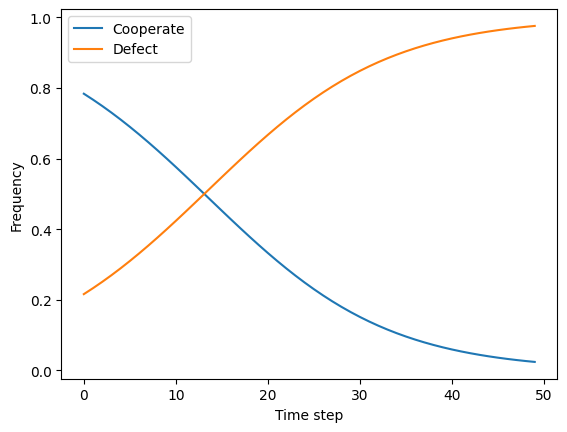

In [262]:
matrix_pd_payoffs = game_payoffs_array(ops_prisoners_dilemma_game)
dyn = dynamics.SinglePopulationDynamics(matrix_pd_payoffs, dynamics.replicator)
x = np.array([0.8, 0.2])
alpha = 0.1
y = []
for i in range(50):
    x += alpha * dyn(x)
    y.append(x.copy())
y = np.array(y)
plt.plot(y[:, 0], label="Cooperate")
plt.plot(y[:, 1], label="Defect")
plt.xlabel("Time step")
plt.ylabel("Frequency")
plt.legend()
plt.show()

<!-- ## Extensive form example: Silly1111 Poker -->

<!-- Silly poker is a variant imperfect information one-card poker game introduced in tutorial 3, but in which there are 3 possible cards (J, Q, K) instead of 2. -->

## Extensive form games from the OpenSpiel library

For extensive form games, OpenSpiel can export to the EFG format used by Gambit. Here we demonstrate this with **Tiny Hanabi**, loaded from the OpenSpiel [game library](https://openspiel.readthedocs.io/en/latest/games.html).


Note: as of OpenSpiel `1.6.1`, many of the games in the game library do not produce correct EFG exports. For example, Kuhn Poker EFG export did not produce a valid `.efg` file for Gambit, giving the error:

```
ValueError: Parse error in game file: Probabilities must sum to exactly one
```

In [23]:
ops_hanabi_game = pyspiel.load_game("tiny_hanabi")
efg_hanabi_game = export_gambit(ops_hanabi_game)
efg_hanabi_game

'EFG 2 R "tiny_hanabi()" { "Pl0" "Pl1" } \nc "" 1 "" { "d0" 0.5000000000000000 "d1" 0.5000000000000000  } 0\n c "p0:d0" 2 "" { "d0" 0.5000000000000000 "d1" 0.5000000000000000  } 0\n  p "" 1 1 "" { "p0a0" "p0a1" "p0a2"  } 0\n   p "" 2 1 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 1 "" { 10.0 10.0 }\n    t "" 2 "" { 0.0 0.0 }\n    t "" 3 "" { 0.0 0.0 }\n   p "" 2 2 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 4 "" { 4.0 4.0 }\n    t "" 5 "" { 8.0 8.0 }\n    t "" 6 "" { 4.0 4.0 }\n   p "" 2 3 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 7 "" { 10.0 10.0 }\n    t "" 8 "" { 0.0 0.0 }\n    t "" 9 "" { 0.0 0.0 }\n  p "" 1 1 "" { "p0a0" "p0a1" "p0a2"  } 0\n   p "" 2 4 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 10 "" { 0.0 0.0 }\n    t "" 11 "" { 0.0 0.0 }\n    t "" 12 "" { 10.0 10.0 }\n   p "" 2 5 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 13 "" { 4.0 4.0 }\n    t "" 14 "" { 8.0 8.0 }\n    t "" 15 "" { 4.0 4.0 }\n   p "" 2 6 "" { "p1a0" "p1a1" "p1a2"  } 0\n    t "" 16 "" { 0.0 0.0 }\n    t "" 17 "" { 0.0 0.0

Now let's load the EFG in Gambit (bear in mind that Gambit's `read_efg` function expects a file like object).

In [24]:
gbt_hanabi_game = gbt.read_efg(StringIO(efg_hanabi_game))
gbt_hanabi_game

Game(title='tiny_hanabi()')

In [25]:
for p in gbt_hanabi_game.players:
    print(p.label)

Pl0
Pl1


In [26]:
eqm = gbt.nash.lcp_solve(gbt_hanabi_game).equilibria[0]
eqm

[[[Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)]], [[Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)], [Rational(1, 1), Rational(0, 1), Rational(0, 1)], [Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)], [Rational(0, 1), Rational(0, 1), Rational(1, 1)]]]

In [27]:
type(eqm)

pygambit.gambit.MixedBehaviorProfileRational

In [28]:
eqm['Pl0']

[[Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)]]

In [29]:
for infoset, mixed_action in eqm["Pl0"].mixed_actions():
    print(
        f"At information set {infoset.number}, "
        f"Player 0 plays action 0 with probability: {mixed_action['p0a0']}"
        f" and action 1 with probability: {mixed_action['p0a1']}"
        f" and action 2 with probability: {mixed_action['p0a2']}"
    )

At information set 0, Player 0 plays action 0 with probability: 0 and action 1 with probability: 0 and action 2 with probability: 1
At information set 1, Player 0 plays action 0 with probability: 0 and action 1 with probability: 1 and action 2 with probability: 0


In [30]:
eqm['Pl1']

[[Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)], [Rational(1, 1), Rational(0, 1), Rational(0, 1)], [Rational(0, 1), Rational(0, 1), Rational(1, 1)], [Rational(0, 1), Rational(1, 1), Rational(0, 1)], [Rational(0, 1), Rational(0, 1), Rational(1, 1)]]

In [31]:
for infoset, mixed_action in eqm["Pl1"].mixed_actions():
    print(
        f"At information set {infoset.number}, "
        f"Player 1 plays action 0 with probability: {mixed_action['p1a0']}"
        f" and action 1 with probability: {mixed_action['p1a1']}"
        f" and action 2 with probability: {mixed_action['p1a2']}"
    )

At information set 0, Player 1 plays action 0 with probability: 0 and action 1 with probability: 0 and action 2 with probability: 1
At information set 1, Player 1 plays action 0 with probability: 0 and action 1 with probability: 1 and action 2 with probability: 0
At information set 2, Player 1 plays action 0 with probability: 1 and action 1 with probability: 0 and action 2 with probability: 0
At information set 3, Player 1 plays action 0 with probability: 0 and action 1 with probability: 0 and action 2 with probability: 1
At information set 4, Player 1 plays action 0 with probability: 0 and action 1 with probability: 1 and action 2 with probability: 0
At information set 5, Player 1 plays action 0 with probability: 0 and action 1 with probability: 0 and action 2 with probability: 1


Let's now train 2 agents using independent Q-learning on Tiny Hanabi, and play them against eachother.

We can compare the learned strategies played to the equilibrium strategies computed by Gambit.

First let's open the RL environment for Tiny Hanabi and create the agents, one for each player (2 players in this case):

In [32]:
# Create the environment
env = rl_environment.Environment("tiny_hanabi")
num_players = env.num_players
num_actions = env.action_spec()["num_actions"]

# Create the agents
agents = [
    tabular_qlearner.QLearner(player_id=idx, num_actions=num_actions)
    for idx in range(num_players)
]

Now we can train the Q-learning agents in self-play.

In [33]:
for cur_episode in range(25000):
  if cur_episode % 1000 == 0:
    print(f"Episodes: {cur_episode}")
  time_step = env.reset()
  while not time_step.last():
    player_id = time_step.observations["current_player"]
    agent_output = agents[player_id].step(time_step)
    time_step = env.step([agent_output.action])
  # Episode is over, step all agents with final info state.
  for agent in agents:
    agent.step(time_step)
print("Done!")

Episodes: 0
Episodes: 1000
Episodes: 2000
Episodes: 3000
Episodes: 4000
Episodes: 5000
Episodes: 6000
Episodes: 7000
Episodes: 8000
Episodes: 9000
Episodes: 10000
Episodes: 11000
Episodes: 12000
Episodes: 13000
Episodes: 14000
Episodes: 15000
Episodes: 16000
Episodes: 17000
Episodes: 18000
Episodes: 19000
Episodes: 20000
Episodes: 21000
Episodes: 22000
Episodes: 23000
Episodes: 24000
Done!


In [34]:
# Evaluate the Q-learning agent against another
eval_agents = [agents[0], agents[1]]

time_step = env.reset()
while not time_step.last():
  print("")
  print(env.get_state)
  player_id = time_step.observations["current_player"]
  # Note the evaluation flag. A Q-learner will set epsilon=0 here.
  agent_output = eval_agents[player_id].step(time_step, is_evaluation=True)
  print(f"Agent {player_id} chooses {env.get_state.action_to_string(agent_output.action)}")
  time_step = env.step([agent_output.action])

print("")
print(env.get_state)
print(time_step.rewards)


p0:d1 p1:d1
Agent 0 chooses p0a1

p0:d1 p1:d1 p0:a1
Agent 1 chooses p1a1

p0:d1 p1:d1 p0:a1 p1:a1
[8.0, 8.0]


Is this one of the equilibrium strategies computed by Gambit?

When I ran the above I got the final game state `p0:d0 p1:d0 p0:a2 p1:a0` with payoffs `[10.0, 10.0]`.

The node `p0:d0 p1:d0` is part of player 0's information set 0. p0 picks a2 which matches the first equilibrium strategy in `eqm['Pl0']` where action `p0a2` is played with probability 1.0. This put's player 1 in their information set 2, and player 1 picks action 0, which is consistent with `eqm['Pl1']` where action `p1a0` is played with probability 1.0.

## Extensive form games created with Gambit

# Extra

```
pyspiel.create_matrix_game()
pyspiel.create_repeated_game()
pyspiel.create_tensor_game()
```

In [63]:
# 1. Create a matrix game (2-player, 2x2 Battle of the Sexes)

# Player payoff matrices for Battle of the Sexes
# Player 1 payoffs: prefers Opera (top-left), Player 2 payoffs: prefers Football (bottom-right)
p1_payoffs = [[3, 0], [0, 1]]  # Player 1: (Opera,Opera)=3, (Football,Football)=1, others=0
p2_payoffs = [[1, 0], [0, 3]]  # Player 2: (Opera,Opera)=1, (Football,Football)=3, others=0

# Create matrix game with named strategies
row_names = ["Opera", "Football"]
col_names = ["Opera", "Football"]
matrix_game_named = pyspiel.create_matrix_game(
    "Battle of Sexes", "Coordination game", row_names, col_names, p1_payoffs, p2_payoffs
)
print(f"Named matrix game: {matrix_game_named.get_type().short_name}")
print(f"Players: {matrix_game_named.num_players()}")

Named matrix game: Battle of Sexes
Players: 2


In [48]:
gbt.read_nfg(StringIO(pyspiel.game_to_nfg_string(matrix_game_named)))

,1,2
1,"3,1","0,0"
2,"0,0","1,3"


In [61]:
# 2. Create a tensor game (3-player, 2x2x2 game)
# Each player has 2 actions, creating 2^3 = 8 possible outcomes

# Create 2x2x2 payoff tensors for 3 players
p1_array = np.array([[[2, 1], [0, 3]], [[1, 2], [3, 0]]])  # Player 1's payoffs
p2_array = np.array([[[1, 2], [3, 0]], [[2, 1], [0, 3]]])  # Player 2's payoffs
p3_array = np.array([[[0, 3], [1, 2]], [[3, 0], [2, 1]]])  # Player 3's payoffs

action_names = [["Cooperate", "Defect"], ["Cooperate", "Defect"], ["Cooperate", "Defect"]]

# Flattened utilities for use in create_tensor_game
flat_utilities = [
    p1_array.flatten().tolist(),
    p2_array.flatten().tolist(), 
    p3_array.flatten().tolist()
]

# Create tensor game with named actions
tensor_game_named = pyspiel.create_tensor_game(
    "3-Player Game", "Multi-player coordination", action_names, flat_utilities
)
print(f"Named tensor game: {tensor_game_named.get_type().short_name}")
print(f"Players: {tensor_game_named.num_players()}")

Named tensor game: 3-Player Game
Players: 3


In [57]:
gbt.read_nfg(StringIO(pyspiel.game_to_nfg_string(tensor_game)))

,1,2
1,"2,1,0","0,3,1"
2,"1,2,3","3,0,2"
,1,2
1,"1,2,3","3,0,2"
2,"2,1,0","0,3,1"


## Loading Gambit games into OpenSpiel

the `load_nfg_game` works for nfg's created by OpenSpiel, but not games created by Gambit, where an error is thrown. But you can create normal form game with the funcs above.

In [81]:
nfg_matrix_rps_game

'NFG 1 R "OpenSpiel export of matrix_rps()"\n{ "Player 0" "Player 1" } { 3 3 }\n\n0 0\n1 -1\n-1 1\n-1 1\n0 0\n1 -1\n1 -1\n-1 1\n0 0\n'

In [75]:
restored_ops_rps_game = pyspiel.load_nfg_game(nfg_matrix_rps_game)
game_payoffs_array(restored_ops_rps_game)

array([[[ 0., -1.,  1.],
        [ 1.,  0., -1.],
        [-1.,  1.,  0.]],

       [[ 0.,  1., -1.],
        [-1.,  0.,  1.],
        [ 1., -1.,  0.]]])

In [65]:
gbt_one_card_poker = gbt.read_efg("../poker.efg")
gbt_one_card_poker

Game(title='One card poker game, after Myerson (1991)')

In [68]:
with open("../poker.efg", "r") as f:
    poker_efg_string = f.read()
    ops_one_card_poker = pyspiel.load_efg_game(poker_efg_string)
ops_one_card_poker

efg_game()

In [96]:
ops_one_card_poker.num_distinct_actions()

4

In [113]:
# Chance nodes.
state = ops_one_card_poker.new_initial_state()
print(state.current_player())     # special chance player id
print(state.is_chance_node())
print(state.chance_outcomes())    # distibution over outcomes as a list of (outcome, probability) pairs

-1
True
[(0, 0.5), (1, 0.5)]


In [114]:
# Applying chance node outcomes: same function as applying actions.
state.apply_action(0)              # Alice chooses the first card (king?)
print(state.is_chance_node())      # no longer at a chance node
print(state.current_player())      # Player 0 (Alice) turn

False
0


In [115]:
print(state)                              # ground/world state (all information open)
print(state.legal_actions())
state.apply_action(0) # Alice chooses raise
print(state.current_player())

1: Player:  1 1  Raise Fold

[0, 1]
1


In [116]:
print(state)                              # ground/world state (all information open)
print(state.legal_actions())
state.apply_action(3) # Bob chooses pass
print(state)

3: Player:  2 1  Meet Pass

[2, 3]
6: Terminal:  Alice wins 1 -1

